# "Cool Deep Learning Stuff - 2 : Transfer Learning, Data augmentation and Progressive Resizing"
 > "Turbo charging the deep learning models. Also the only Progressive Resizing guide you find for Tensorflow"

- toc:true
- branch: master
- badges: true
- comments: true
- author: Vishal
- categories: [Deep Learning, Computer Vision, Theory, Tensorflow, Progressive Resizing, Transfer Learning, Imagenette]

# Let's download the data again...

In [1]:
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

--2021-01-24 16:40:30--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.36.134
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.36.134|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1556914727 (1.4G) [application/x-tar]
Saving to: ‘imagenette2.tgz’

imagenette2.tgz     100%[===================>]   1.45G   109MB/s    in 16s     

2021-01-24 16:40:46 (93.8 MB/s) - ‘imagenette2.tgz’ saved [1556914727/1556914727]



In [ ]:
!tar -xzvf /content/imagenette2.tgz

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import layers

from tensorflow.keras.preprocessing import image_dataset_from_directory

Also let us load the images into `dataset` object

# And create a dataset out of it...

>Important: I have saved the dataset on GPU. If you want to save it on the CPU and its ram, remove the third line and unindent the next two lines

In [4]:
train_path = '/content/imagenette2/train'
val_path = '/content/imagenette2/val'
with tf.device('/device:GPU:0'):
  train_data = image_dataset_from_directory(train_path,shuffle=True, image_size=(256,256))
  val_data = image_dataset_from_directory(val_path,shuffle=False,image_size=(256,256))

Found 9469 files belonging to 10 classes.
Found 3925 files belonging to 10 classes.


Lets have look at the images...

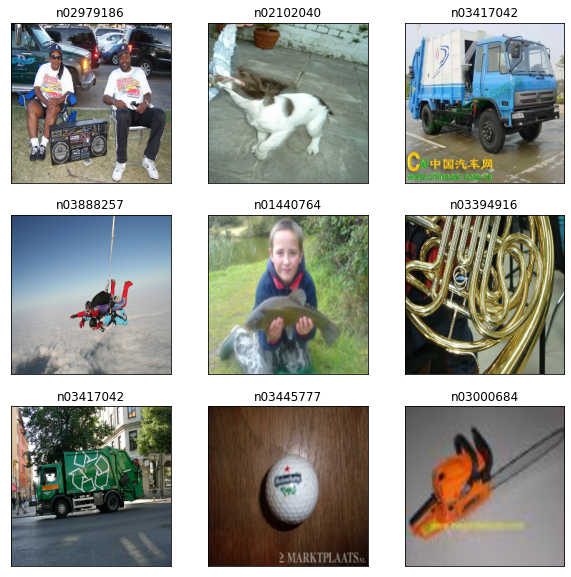

In [5]:
class_names = train_data.class_names

plt.figure(figsize=(10,10))

for images, labels in train_data.take(1):
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255) 
    plt.title(class_names[labels[i]])
    plt.xticks([])
    plt.yticks([])

# Transfer Learning

![](https://dudeperf3ct.github.io/images/transfer_learning_files/transfer_learning_meme.jpeg)

Everybody's telling transfer learning. But what is transfer learning. Let me tell you an analogy. Imagine you've a physics test in an hour, and you didn't study for it. You pray that, I wish I had **Albert Einstein**'s brain. Gods were kind that day and suddenly you had Einstein's brain transferred into you. You write well and and ace the test. Sounds like a fairy tale right?

Well, what if I tell, we are going to stage that exact fairy tale for our Imagenette problem?

Remember from last [blog post](https://thecoolstuff.tech/deep%20learning/computer%20vision/theory/tensorflow/2021/01/13/cool-deep-learning-stuff-1.html#Convolutional-Neural-Network) our model performed badly even after 30 epochs. As I told, Neural networks need millions of training images and millions of epochs to get the good understanding of the mapping between training data and real life problem. But we should not simply waste that training by creating a model from scratch every time. 

It would be intuitive if we always draw parallels between training the neural network and training an actual human being. If you're learning cycling, initially it'll be hard and you'll fall down lot of time. But once you've learnt it, you aren't going to learn how to ride different cycles and two wheelers from scratch. Instead you'll **finetune** your sense of balance for that particular vehicle. Exactly the same thing with Neural Networks. You train the neural network for a general task, and finetune the trained network for the particular problems.

You may wonder why this works. Have a look at this image. ![Image from: https://medium.com/analytics-vidhya/deep-learning-visualization-and-interpretation-of-neural-networks-2f3f82f501c5](https://miro.medium.com/max/700/1*WysCJ6Ynecvviwctt6WDlQ.png)

There are the representation of layers of **trained convnet**, i.e, the patters each layers are being sensitive too. It is arranged in a such a way that, the first few layers, middle layers and end layers left to right. You can see the first few layers learnt to detect straight lines and gradients at different directions. The middle layers learnt the combinations of those lines from first layer like circles, corners, etc. The last layers combined the shapes from middle layers into complex shapes like wheel, face etc. So irrespective of the dataset we train on, the first layers and some of the middle layers always going to get the representation such elementary shapes only. So instead of wasting time in learning to the lines and circles from scratch, we'll get some pretrained model and fine tune the end layers to the complex shapes that represents the dataset.

As a benchmark, all the significant models are trained on **imagenet** dataset and most of them have their weights available for us to download. Thats why imagenet dataset is so famous and important. In this case we will download **Resnet50V2** model (more on architectures in later posts...) from tensorflow repository and call it as ```base_model```. We can access the individual layers of a model by using ```layers``` attribute of ```model``` class. We'll then freeze the first 150 layers of the model as we don't need to change the learnt representation of elementary shapes by setting ```layers.trainable``` to ```False```. We then manually create the final part of the network, by converting the square output of our CNN to single dimension using ```GlobalMaxPooling2d()``` and ```Flattten()``` layer. Then we connect fully connected layers having 1024 hidden units and 10 output units (number of classes...). 

> Note: More on ```Dropout``` layer later...

In [6]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(256,256,3),include_top=False,weights='imagenet')
head_model = base_model
for layers in base_model.layers[:150]:
  layers.trainable=False
head_model = head_model.output
head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
head_model = tf.keras.layers.Dropout(0.2)(head_model)
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')(head_model)
model = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)

94674944/94668760 [==============================] - 0s 0us/step


Remember we used ```Adam``` optimizer? Well, adam is known for converging fast, there is other optimizer in the town, ```sgd```, which expands to **Stochastic Gradient Descent**. It may quite sound mouthful, but its very simple indeed. The original Gradient Descent calculated gradient for entire dataset, our Stochastic Gradient Descent computes gradient for some small subset of dataset at a time. It is slower compared to Adam, but it can converge to more accurate weights. More on upcoming optimizer blog post...

In [7]:
model.compile(optimizer='sgd',loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','AUC'])

We'll now use ```ImageDataGenerator``` class to fetch data from the hard disk to the model. It's very useful, I'll tell you why in an moment. We first instantiate the ```train_datagen``` and ```validation_datagen``` objects. Don't worry about the parameters inside it now, I'll tell you about it in moment. Then we use ```flow_from_directory``` method to say where the training and validation data exists, and set parameters like batch size and image size.

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range=0.2,
    zoom_range = 0.2,
    rotation_range = 0.125
)
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(256,256))

validation_datagen = ImageDataGenerator( rescale = 1.0/255.)
validation_generator = train_datagen.flow_from_directory(val_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


>Important: I have used GPU to accelerate the training on Colab (which is totally free XD). If you want to train your model in cpu instead, remove the first line in the cell below and unindent the second line.

In [9]:
with tf.device('/device:GPU:0'):
  model.fit(train_generator,epochs=3,validation_data=validation_generator)

Epoch 1/3
474/474 [==============================] - 246s 499ms/step - loss: 1.6907 - accuracy: 0.8396 - auc: 0.9565 - val_loss: 0.1122 - val_accuracy: 0.9674 - val_auc: 0.9984
Epoch 2/3
474/474 [==============================] - 235s 495ms/step - loss: 0.0985 - accuracy: 0.9716 - auc: 0.9984 - val_loss: 0.1029 - val_accuracy: 0.9669 - val_auc: 0.9987
Epoch 3/3
474/474 [==============================] - 235s 496ms/step - loss: 0.0572 - accuracy: 0.9821 - auc: 0.9997 - val_loss: 0.1187 - val_accuracy: 0.9687 - val_auc: 0.9962


You can see, that after only 3 epochs the validation accuracy is 96%. This is the power of Transfer Learning. Infact this transfer learning democratised the field of Deep Learning, from only big enterprises with huge datasets and powerful machines can train neural networks to even a common teenager with internet connection can produce state-of-art results in small dataset in an google colab instance. Let's take a break to appreciate the Transfer Learning and its groundbreaking change in field of Deep learning before making it even more better.

# Data Augmentation

Have a look at this cute little fella, 

<img src="my_icons/cat.jpg" width="350"/>

Let's name him, Jack. Say hii to Jack. Let me show you few more pictures, 

<img src="my_icons/cat2.jpg" width="350"/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 

<img src="my_icons/cat4.jpg" width="350"/>

The first image is still Jack right? Zoomed in a bit, but still its our Jack. What about the second image? That's definitely Jack, but flipped horizontally. So if we train a CNN classifier to detect whether this is Jack or not, all the three images must be classified as Jack. This process, to tweak the input image little bit to create new data samples is called, **Data Augmentation**

Along with Transfer Learning, Data Augmentation also revolutionized deep learning by enabling us to multiply our small dataset into manifolds. Apart from more training samples, it also helps the model to generalize better, because instead of a model remembering a cat that lies on right side of bed as Jack, now the model should remember the facial features of Jack. In short, it prevents the model performing a cheap trick called **Overfitting**(More on it, in later blog posts...)

Now let's come back to ```ImageDataGenerator``` class. By saying we're doing data augmentation, that means we are feeding the model with multiple copies of same but slightly tweaked images. But creating multiple copies will cost us lot of storage if we are dealing with large dataset. This is where ```ImageDataGenerator``` helps us. It basically acts as the bridge between images in hard disk and our Model in RAM or VRAM. While the training is in progress, it will fetch few images and apply the augmentation operations specified by users and eventually multiply the number of images and feed it to model so that the extra copies of images aren't saved. You can see the available data augmentations [here](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator).

```
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    shear_range=0.2,
    zoom_range = 0.2,
    rotation_range = 0.125
)
```

> Warning: As I said before, its beneficial to draw parallels between real life and training models. Here looking at a cat flipped upside down, might not really make sense. Because, we aren't going to see upside down cats in real life that often. So its wise to set ```vertical_flip``` to false. Similarly, we should think whether a particular data augmentation will make sense with respect to the real life problem we are dealing with, before applying it.

# Progressive Resizing

With both **Transfer Learning** and **Data Augmentation** in hand, lets do something really really cool. So the size of image is directly proportional to training time. That is pretty intuitive right? Large size means more pixels, so more time to go through a single image. But according to data augmentation, the model should be resilient to minor tweaks in data. Which means image with smaller size than actual training image should teach "some amount" to the model. So here's the idea, we'll first train the same model with much smaller image size, then progressively increase the size of image. So first we instantiate the data generator with images resized to 64x64 (remember the original image sizes were 256x256)

In [10]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(64,64))

validation_generator = train_datagen.flow_from_directory(val_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(64, 64))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


Then, we create same old model and train it with 64x64 images for 1 epoch

In [11]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(256,256,3),include_top=False,weights='imagenet')
head_model = base_model
for layers in base_model.layers[:150]:
  layers.trainable=False
head_model = head_model.output
head_model = tf.keras.layers.GlobalMaxPooling2D()(head_model)
head_model = tf.keras.layers.Flatten(name="Flatten")(head_model)
head_model = tf.keras.layers.Dense(1024,activation='relu')(head_model)
head_model = tf.keras.layers.Dropout(0.2)(head_model)
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')(head_model)
model_pr = tf.keras.Model(inputs=base_model.input,outputs=prediction_layer)

In [12]:
model_pr.compile(optimizer='sgd',loss=tf.keras.losses.CategoricalCrossentropy(),
                 metrics=['accuracy','AUC'])

In [13]:
with tf.device('/device:GPU:0'):
  model_pr.fit(train_generator,epochs=1,validation_data=validation_generator)

474/474 [==============================] - 83s 168ms/step - loss: 1.5958 - accuracy: 0.5279 - auc: 0.8606 - val_loss: 0.7506 - val_accuracy: 0.7585 - val_auc: 0.9653


This epoch went very fast, but accuracy is not good. Now we'll reinstantiate the data generators with 128x128 images and repeat the process.

In [14]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(128,128))

validation_generator = train_datagen.flow_from_directory(val_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(128, 128))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


> Note: We aren't reinstantiating new model. But instead we are running second epoch on the model which is previously trained onn 64x64 images. This is essentially transfer learning.

In [15]:
with tf.device('/device:GPU:0'):
  model_pr.fit(train_generator,epochs=1,validation_data=validation_generator)

474/474 [==============================] - 112s 234ms/step - loss: 0.4731 - accuracy: 0.8536 - auc: 0.9838 - val_loss: 0.3097 - val_accuracy: 0.9009 - val_auc: 0.9927


The accuracy is getting better. Finally let's train on the original 256x256 images.

In [16]:
train_generator = train_datagen.flow_from_directory(train_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(256,256))

validation_generator = train_datagen.flow_from_directory(val_path,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(256, 256))

Found 9469 images belonging to 10 classes.
Found 3925 images belonging to 10 classes.


In [17]:
with tf.device('/device:GPU:0'):
  model_pr.fit(train_generator,epochs=1,validation_data=validation_generator)

474/474 [==============================] - 237s 500ms/step - loss: 0.1857 - accuracy: 0.9457 - auc: 0.9952 - val_loss: 0.1091 - val_accuracy: 0.9638 - val_auc: 0.9987


Note that we have achieved 96% of validation accuracy which is same as the accuracy of pre-trained model finetuned 3 epochs. But the key is how much fast we did this. From the output of training step, we can get the time it took for each epoch...

In [18]:
246 + 235 + 235

716

When we trained without progressive resizing, it took 716 seconds

In [19]:
83 + 112 + 237

432

And when we used progressive resizing, it only took 432 seconds. Which is almost 300 seconds faster.

In [2]:
432/716 *100

60.33519553072626

And if do the math, Progressive resizing makes the training process 60% faster. Also note that training accuracy > validation accuracy without progressive resizing. Which means the model started overfitting, but since its in small amount. But while we are doing progressive resizing, validation accuracy > training accuracy, which means the model generalized very well and more resilient in the real world problem.

This is very very cool right? We can get better models in less time. Make sure you start using progressive resizing as your routine while training process. By this, we reach the end of this blog post. Please share your thoughts about this post below and also feel free to reach me out on my social handles. 😁😁😁